# Source localization problem
You are given a square domain in which there are placed sensors. An impulse source is placed in the domain and fires at $T_{trigger}$. Each sensor registers the time it has received the impulse. Find the position of the source, if the propagation dynamic is:

$$ T_i = T_{trigger} + \sqrt{(\frac{x - x_i}{v_x})^2 + (\frac{y - y_i}{v_y})^2} $$

where $(x,y)$ is the position of the source

In [1]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt

In [2]:
from loss import *
from problem import *
from solver import *

## Graphical intuition

In [3]:
from visualization import (plot_activation_field,
                           plot_loss_landscape)

In [4]:
problem = SingleSourceProblem.generate_random_instance(11)

### Activation field

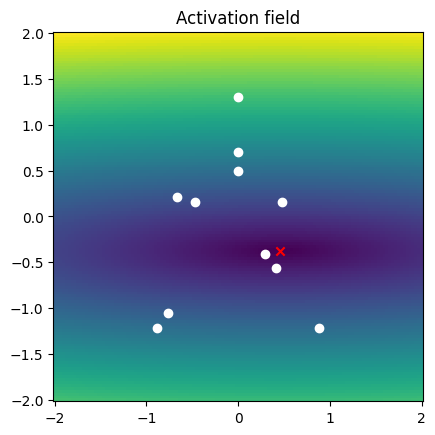

In [5]:
plot_activation_field(problem)

This plot is deceitful: one may think that the loss function is very regular and the problem is well conditioned. Experiments have shown that the loss function is not convex, otherwise we would have always convergence.

### Loss landscape

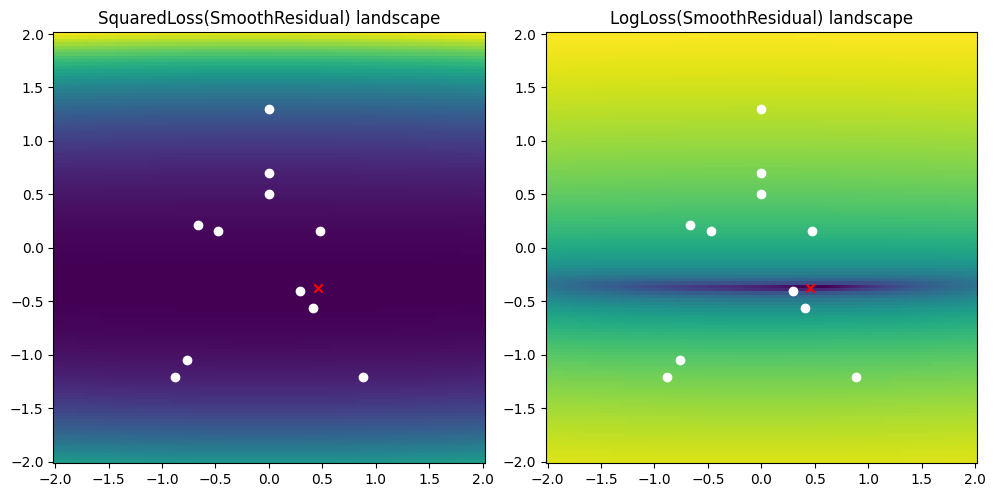

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10,6))

plot_loss_landscape(problem,
                    SmoothResidual(),
                    SquaredLoss(),
                    ax[0])

plot_loss_landscape(problem,
                    SmoothResidual(),
                    LogLoss(),
                    ax[1])

plt.tight_layout()

### Loss discontinuities

In [7]:
def plot_loss_discontinuities(problem: SingleSourceProblem,
                              residual_obj: ResidualInterface,
                              loss_obj: LossInterface,
                              ax = None):
    if ax is None:
        _, ax = plt.subplots()

    x = np.linspace(-2*L, 2*L)
    y = problem.source_location[1] * np.ones_like(x)
    sample_points = np.array([x, y]).T

    loss_on_row = loss_obj(residual_obj(sample_points, problem))

    ax.plot(x, loss_on_row)
    ax.set_title("Loss on row")

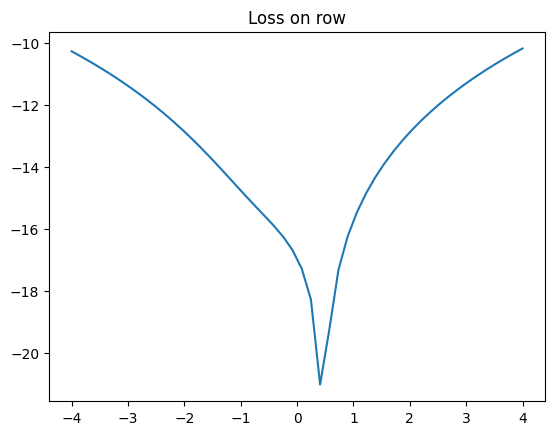

In [8]:
plot_loss_discontinuities(problem, SmoothResidual(), LogLoss())

# Optimization

In [9]:
def sample_optimizer_fails(solver: SolverInterface, sensor_sizes: np.array, nruns_per_bin: int, error_threshold: float = 1e-3):
    fails = np.zeros(sensor_sizes.shape[0])

    for (i, sensor_size) in enumerate(sensor_sizes):
        for _ in range(nruns_per_bin):
            problem = SingleSourceProblem.generate_random_instance(sensor_size)

            # try:
            #     expected_source_location = solver.solve(
            #         problem=problem,
            #         x0=np.array([0.0, 0.0])
            #     ).x
            #     error = np.linalg.norm(expected_source_location - problem.source_location)

            # except ValueError:
            #     error = np.inf

            expected_source_location = solver.solve(
                problem=problem,
                x0=np.array([0.0, 0.0])
            ).x
            error = np.linalg.norm(expected_source_location - problem.source_location)

            if error > error_threshold:
                fails[i] += 1

    return sensor_sizes, fails

In [10]:
import multiprocessing
from functools import partial

In [11]:
def test_optimizer_fails(sensor_sizes: np.array, nruns_per_bin: int, solvers: list[SolverInterface], error_threshold: float = 1e-3, pool_size: int = 8):
    fig, ax = plt.subplots(figsize=(10,6))

    with multiprocessing.Pool(pool_size) as p:
        samples = p.map(
            partial(sample_optimizer_fails, sensor_sizes=sensor_sizes, nruns_per_bin=nruns_per_bin, error_threshold=error_threshold),
            solvers
        )

    for (sensor_size, fails), solver in zip(samples, solvers):
        ax.plot(sensor_sizes, fails/nruns_per_bin, label=str(solver))

    ax.set_xticks(sensor_sizes)
    ax.set_xlabel('# sensors used')
    ax.set_ylabel('fail frequency')

    ax.set_title(f"Fails in optimization procedure ($\\epsilon = ${error_threshold: .2g})")
    plt.legend()

/home/matteo/experiments/numerics/radar/loss.py:27: RuntimeWarning: invalid value encountered in divide
  result = -diffs / (np.linalg.norm(diffs, axis=-1, keepdims=True) * problem.velocity)


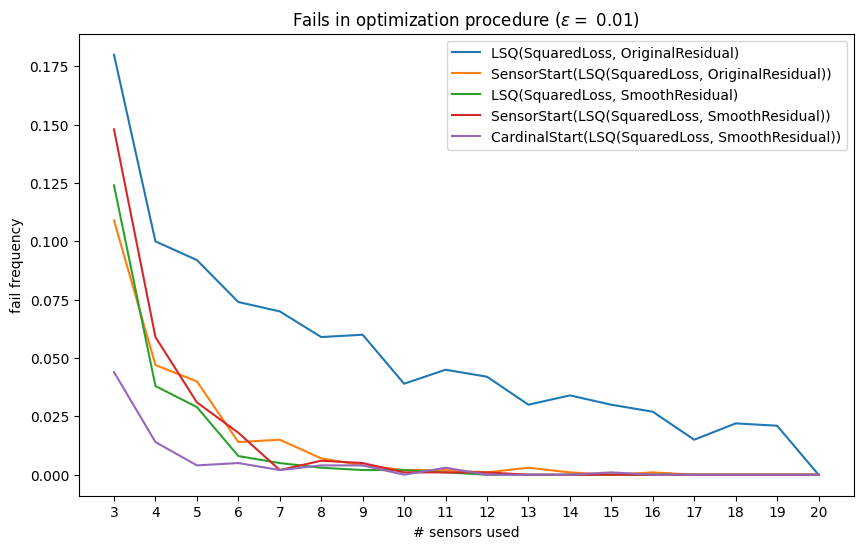

In [12]:
test_optimizer_fails(
    sensor_sizes=np.arange(3, SENSOR_LOCATIONS.shape[0]+1),
    nruns_per_bin=1000,
    solvers=[
        LeastSquaresSolver(Residual(), SquaredLoss()),
        SensorStartSolver(LeastSquaresSolver(Residual(), SquaredLoss())),
        LeastSquaresSolver(SmoothResidual(), SquaredLoss()),
        SensorStartSolver(LeastSquaresSolver(SmoothResidual(), SquaredLoss())),
        CardinalStartSolver(LeastSquaresSolver(SmoothResidual(), SquaredLoss())),
    ],
    error_threshold=1e-2
)

/home/matteo/experiments/numerics/radar/loss.py:27: RuntimeWarning: invalid value encountered in divide
  result = -diffs / (np.linalg.norm(diffs, axis=-1, keepdims=True) * problem.velocity)


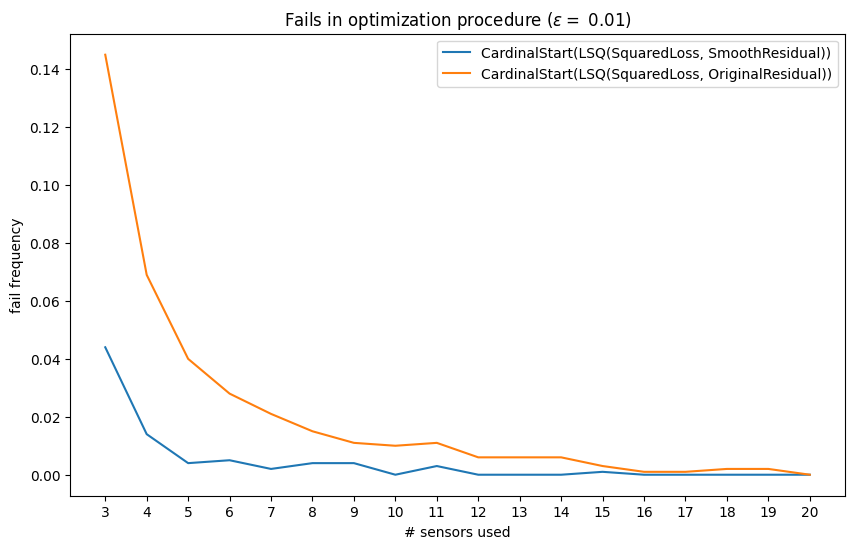

In [13]:
test_optimizer_fails(
    sensor_sizes=np.arange(3, SENSOR_LOCATIONS.shape[0]+1),
    nruns_per_bin=1000,
    solvers=[
        CardinalStartSolver(LeastSquaresSolver(SmoothResidual(), SquaredLoss())),
        CardinalStartSolver(LeastSquaresSolver(Residual(), SquaredLoss())),
    ],
    error_threshold=1e-2
)

## Why the optimization fails?

In [14]:
def get_first_failure(solver: SolverInterface, size: int, maxit: int, error_threshold: float = 1e-2):
    for _ in range(maxit):
        problem = SingleSourceProblem.generate_random_instance(size)

        try:
            optimize_result = solver.solve(
                problem=problem,
                x0=np.array([0.0, 0.0])
            )

            expected_source_location = optimize_result.x
            error = np.linalg.norm(expected_source_location - problem.source_location)

        except ValueError:
            error = np.inf

        if error > error_threshold:
            return (problem, optimize_result)

    return None


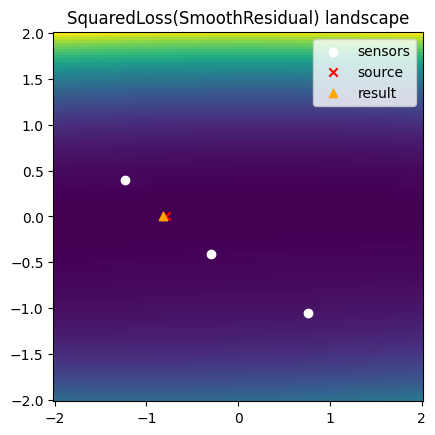

In [15]:
failed_problem, optimize_result = get_first_failure(
    solver=CardinalStartSolver(LeastSquaresSolver(SmoothResidual(), SquaredLoss())),
    size=3,
    maxit=10_000
)

plot_loss_landscape(failed_problem, SmoothResidual(), SquaredLoss())
plt.scatter(optimize_result.x[0], optimize_result.x[1], marker='^', c='orange', label='result')
plt.legend()
plt.show()

In [16]:
def compute_attractor(problem: SingleSourceProblem,
                      solver: SolverInterface,
                      resolution: int = 50):

    x = np.linspace(-L, L, resolution)
    y = np.linspace(-L, L, resolution)

    X, Y = np.meshgrid(x, y)
    Z = np.zeros((resolution, resolution, 2))

    for i in range(resolution):
        for j in range(resolution):
            x0 = np.array([X[i,j], Y[i,j]])

            optimize_result = solver.solve(
                problem=problem,
                x0=x0
            )

            Z[i,j] = optimize_result.x

    return X, Y, Z

In [17]:
import scipy.cluster.vq as vq
from matplotlib.colors import ListedColormap

def plot_attractor_field(problem: SingleSourceProblem,
                         solver: SolverInterface,
                         resolution: int = 50,
                         ax = None):

    assert(not solver.overrides_initial_guess())

    if ax is None:
        fig, ax = plt.subplots()

    X, Y, Z = compute_attractor(problem,
                                solver,
                                resolution)

    # cluster points in Z with 2 clusters
    centroids, labels = vq.kmeans2(Z.reshape(-1, 2), 2, minit='points')

    custom_cmap = ListedColormap(['lightcoral', 'lightgreen'])

    ax.set_title(f"Attractor field for {solver.residual_obj}")
    ax.pcolormesh(X, Y, labels.reshape(resolution, resolution), cmap=custom_cmap, alpha=0.5)
    ax.scatter(centroids[:,0], centroids[:,1], marker='^', c='blue', label='attractors')
    ax.scatter(problem.source_location[0], problem.source_location[1], marker='x', c='red', label='source')
    ax.set_xlim(-L, L)
    ax.set_ylim(-L, L)
    ax.set_aspect('equal')

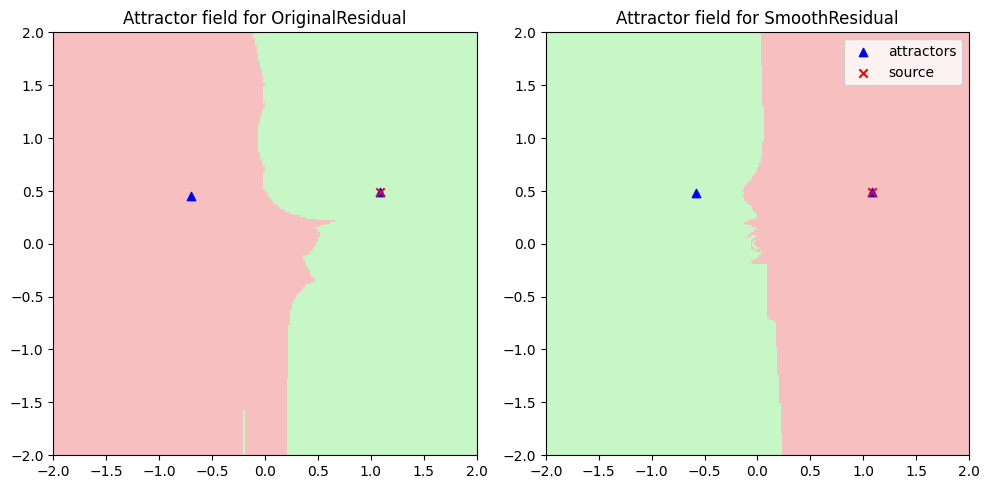

In [18]:
residual_obj = SmoothResidual()
loss_obj = SquaredLoss()
solver = LeastSquaresSolver(residual_obj, loss_obj)

result = get_first_failure(solver,
                           size=7,
                           maxit=10000,
                           error_threshold=1e-1)

if result is not None:
    failed_problem, optimize_result = result
    x = optimize_result.x

    fig, ax = plt.subplots(1, 2, figsize=(10,6))

    plot_attractor_field(failed_problem,
                         solver=LeastSquaresSolver(Residual(), SquaredLoss()),
                         resolution=256,
                         ax=ax[0])

    plot_attractor_field(failed_problem,
                         solver=LeastSquaresSolver(SmoothResidual(), SquaredLoss()),
                         resolution=256,
                         ax=ax[1])

    plt.legend()
    plt.tight_layout()